# Movie Recommendation system

## Import Library

In [448]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Filter out specific warning by category
warnings.filterwarnings("ignore")
# Your code here that triggers the warning
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Data Understanding

### Data Loading

In [449]:
movies_df = pd.read_csv("/content/drive/MyDrive/portofolio/Movie Recommendation System/Dataset/movies.csv")
ratings_df = pd.read_csv("/content/drive/MyDrive/portofolio/Movie Recommendation System/Dataset/ratings.csv")

In [450]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [451]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [452]:
print('Jumlah data movies: ', len(movies_df.movieId.unique()))
print('Jumlah data ratings: ', len(ratings_df.movieId.unique()))

Jumlah data movies:  9742
Jumlah data ratings:  9724


### Exploratory Data Analysis

In [453]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [454]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [455]:
movies_df.describe(include="all")

,movieId,title,genres
count,9742.000000,9742,9742
unique,NaN,9737,951
top,NaN,Emma (1996),Drama
freq,NaN,2,1053
mean,42200.353623,NaN,NaN
std,52160.494854,NaN,NaN
min,1.000000,NaN,NaN
25%,3248.250000,NaN,NaN
50%,7300.000000,NaN,NaN
75%,76232.000000,NaN,NaN


In [456]:
ratings_df.describe(include="all")

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


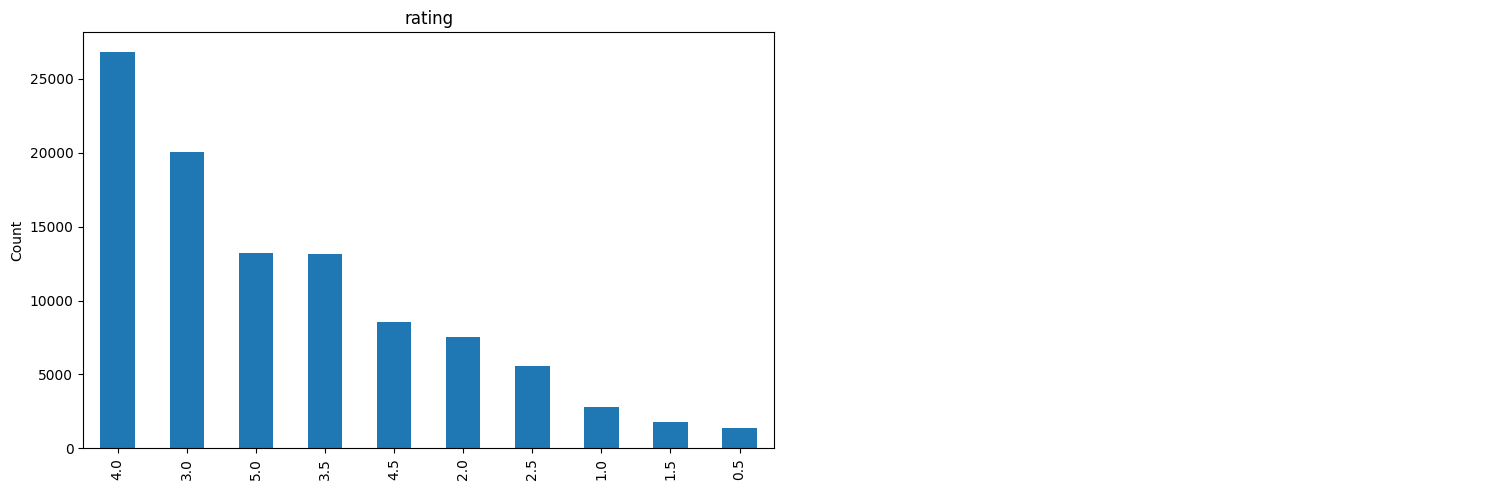

In [457]:
categorical_feats = ['rating']
count_categorical_cols = len(categorical_feats)
num_rows = (count_categorical_cols + 1) // 2  # Calculate the number of rows needed for the grid layout

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5*num_rows))  # Create a grid layout
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for index, col in enumerate(categorical_feats):
    count = ratings_df[col].value_counts()
    percent = 100 * ratings_df[col].value_counts(normalize=True).round(2)
    df = pd.DataFrame({'jumlah sampel': count, 'persentase': percent})
    ax = axes[index]
    count.plot(kind='bar', ax=ax, title=col)
    ax.set_ylabel('Count')

# Hide any remaining empty subplots
for ax in axes[count_categorical_cols:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


## Data Preprocessing

### Merge Data

In [458]:
# menggabungkan data movies dengan rating
movies = pd.merge(movies_df, ratings_df, on='movieId', how='inner')

# Print dataframe movies
movies.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [459]:
print('Jumlah seluruh data movies dan rating berdasarkan movie_id: ', len(movies))

Jumlah seluruh data movies dan rating berdasarkan movie_id:  100836


## Data Preparation

### Change Datatype

In [460]:
movies['movieId'] = movies['movieId'].astype('category')
movies['userId'] = movies['userId'].astype('category')

### Missing Value

Text(0.5, 1.0, 'Count of missing value')

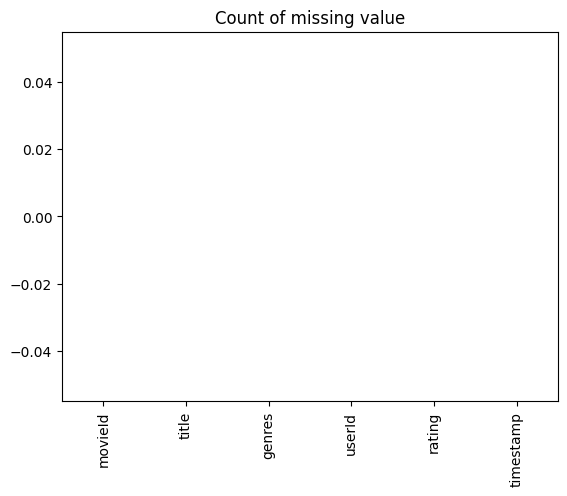

In [461]:
movies.isna().sum().plot(kind="bar")
plt.title("Count of missing value")

In [462]:
# Membuang data duplikat pada variabel preparation
preparation = movies.drop_duplicates('movieId')
preparation

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
215,2,Jumanji (1995),Adventure|Children|Fantasy,6,4.0,845553522
325,3,Grumpier Old Men (1995),Comedy|Romance,1,4.0,964981247
377,4,Waiting to Exhale (1995),Comedy|Drama|Romance,6,3.0,845554349
384,5,Father of the Bride Part II (1995),Comedy,6,5.0,845553938
...,...,...,...,...,...,...
100831,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy,184,4.0,1537109082
100832,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy,184,3.5,1537109545
100833,193585,Flint (2017),Drama,184,3.5,1537109805
100834,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation,184,3.5,1537110021


In [463]:
# Mengonversi data series ‘movieId’ menjadi dalam bentuk list
movieId = preparation['movieId'].tolist()

# Mengonversi data series ‘title’ menjadi dalam bentuk list
movie_title = preparation['title'].tolist()

# Mengonversi data series ‘genre’ menjadi dalam bentuk list
genre = preparation['genres'].tolist()

print(len(movieId))
print(len(movie_title))
print(len(genre))

9724
9724
9724


In [464]:
# Membuat dictionary untuk data ‘movieId’, ‘movie_title’, dan ‘genre’
movie = pd.DataFrame({
    'id': movieId,
    'title': movie_title,
    'genres': genre
})
movie.head()

,id,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Modelling

### Modelling Content Based Filtering

In [465]:
data = movie

# Words to exclude from TF-IDF
exclude_words = ['no', 'fi', 'imax']

# Inisialisasi TfidfVectorizer
vec = TfidfVectorizer(stop_words=exclude_words)

# Melakukan perhitungan idf pada data genres
vec.fit(data['genres'])

# Mapping array dari fitur index integer ke fitur nama
vec.get_feature_names_out()

array(['action', 'adventure', 'animation', 'children', 'comedy', 'crime',
       'documentary', 'drama', 'fantasy', 'film', 'genres', 'horror',
       'listed', 'musical', 'mystery', 'noir', 'romance', 'sci',
       'thriller', 'war', 'western'], dtype=object)

In [466]:
# Melakukan fit lalu ditransformasikan ke bentuk matrix
tfidf_matrix = vec.fit_transform(data['genres'])

# Melihat ukuran matrix tfidf
tfidf_matrix.shape

(9724, 21)

In [467]:
# Membuat dataframe untuk melihat tf-idf matrix
# Kolom diisi dengan genre
# Baris diisi dengan movie title

pd.DataFrame(
    tfidf_matrix.todense(),
    columns=vec.get_feature_names_out(),
    index=data.title
).info()

<class 'pandas.core.frame.DataFrame'>
Index: 9724 entries, Toy Story (1995) to Andrew Dice Clay: Dice Rules (1991)
Data columns (total 21 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   action       9724 non-null   float64
 1   adventure    9724 non-null   float64
 2   animation    9724 non-null   float64
 3   children     9724 non-null   float64
 4   comedy       9724 non-null   float64
 5   crime        9724 non-null   float64
 6   documentary  9724 non-null   float64
 7   drama        9724 non-null   float64
 8   fantasy      9724 non-null   float64
 9   film         9724 non-null   float64
 10  genres       9724 non-null   float64
 11  horror       9724 non-null   float64
 12  listed       9724 non-null   float64
 13  musical      9724 non-null   float64
 14  mystery      9724 non-null   float64
 15  noir         9724 non-null   float64
 16  romance      9724 non-null   float64
 17  sci          9724 non-null   float64
 18  thrille

**Cosine Similiarity**

In [468]:
# Menghitung cosine similarity pada matrix tf-idf
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.81352752, 0.15262722, ..., 0.        , 0.42122062,
        0.26751731],
       [0.81352752, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.15262722, 0.        , 1.        , ..., 0.        , 0.        ,
        0.57053212],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.42122062, 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.26751731, 0.        , 0.57053212, ..., 0.        , 0.        ,
        1.        ]])

In [469]:
# Membuat dataframe dari variabel cosine_sim dengan baris dan kolom berupa nama movie
cosine_sim_df = pd.DataFrame(cosine_sim, index=data['title'], columns=data['title'])
print('Shape:', cosine_sim_df.shape)

# Melihat similarity matrix pada setiap movie
cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9724, 9724)


title,Stage Beauty (2004),The Expendables 3 (2014),"Philadelphia Experiment, The (1984)",Love at First Bite (1979),U2: Rattle and Hum (1988)
title,,,,,
Ali G Indahouse (2002),0.000000,0.000000,0.000000,0.410816,0.0
Major League: Back to the Minors (1998),0.000000,0.000000,0.000000,0.410816,0.0
"Librarian: Return to King Solomon's Mines, The (2006)",0.000000,0.754161,0.356593,0.000000,0.0
Jason's Lyric (1994),0.503700,0.000000,0.188081,0.000000,0.0
Jesus' Son (1999),1.000000,0.000000,0.373399,0.000000,0.0
Bonfire of the Vanities (1990),0.442312,0.000000,0.165159,0.196546,0.0
Before the Fall (NaPolA - Elite für den Führer) (2004),0.391837,0.000000,0.146311,0.000000,0.0
Mr. Brooks (2007),0.405595,0.000000,0.151449,0.000000,0.0
Ant-Man and the Wasp (2018),0.000000,0.613945,0.630830,0.121628,0.0


In [470]:
def movie_recommendation(title, similarity_data=cosine_sim_df, items=data[['title', 'genres']], k=5):
    """
    Rekomendasi movie berdasarkan kemiripan dataframe

    Parameter:
    ---
    title : tipe data string (str)
                Judul Film (index kemiripan dataframe)
    similarity_data : tipe data pd.DataFrame (object)
                      Kesamaan dataframe, simetrik, dengan movie sebagai
                      indeks dan kolom
    items : tipe data pd.DataFrame (object)
            Mengandung kedua nama dan fitur lainnya yang digunakan untuk mendefinisikan kemiripan
    k : tipe data integer (int)
        Banyaknya jumlah rekomendasi yang diberikan
    ---


    Pada index ini, kita mengambil k dengan nilai similarity terbesar
    pada index matrix yang diberikan (i).
    """


    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop title agar nama movie yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

In [471]:
data[data.title.eq('Old Boy (2003)')]

,id,title,genres
5682,27773,Old Boy (2003),Mystery|Thriller


In [472]:
# Mendapatkan rekomendasi movie yang mirip dengan Old Boy (2003)
movie_recommendation('Old Boy (2003)')

,title,genres
0,The Wailing (2016),Mystery|Thriller
1,Memento (2000),Mystery|Thriller
2,Body Double (1984),Mystery|Thriller
3,Saboteur (1942),Mystery|Thriller
4,Pacific Heights (1990),Mystery|Thriller


### Modelling Collaborative Based Filtering

In [473]:
data = movies
data.head()

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0,964982703
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,847434962
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5,1106635946
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5,1510577970
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5,1305696483


In [474]:
# Mengubah rating menjadi nilai float
data['rating'] = data['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(data['rating'])

# Nilai maksimal rating
max_rating = max(data['rating'])
# jumlah user
num_users = len(data['userId'].unique())
num_movies = len(data['movieId'].unique())
print('Number of User: {}, Number of movie: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_movies, min_rating, max_rating
))

Number of User: 610, Number of movie: 9724, Min Rating: 0.5, Max Rating: 5.0


In [475]:
data.describe()

,rating,timestamp
count,100836.000000,1.008360e+05
mean,3.501557,1.205946e+09
std,1.042529,2.162610e+08
min,0.500000,8.281246e+08
25%,3.000000,1.019124e+09
50%,3.500000,1.186087e+09
75%,4.000000,1.435994e+09
max,5.000000,1.537799e+09


In [476]:
# dikarenakan title mencapai 193609 namun jumlah movie hanya 9724, encoding dilakukan terhadap title.
# hal tersebut dapat mempengaruhi hasil karena title dijadikan sebagai index

# Mengubah title menjadi list tanpa nilai yang sama
movie_ids = data['title'].unique().tolist()

# Melakukan proses encoding title
movie_to_movie_encoded = {x: i for i, x in enumerate(movie_ids)}

# Melakukan proses encoding angka ke title
movie_encoded_to_movie = {i: x for i, x in enumerate(movie_ids)}

In [477]:
# begitu juga dengan userId karena dimulai dari 1, sedangkan indexing dimulai 0 hal ini dapat menimbulkan error pada saat training model
# maka dari itu, userId akan dilakukan encoding seperti movieId

# Mengubah userId menjadi list tanpa nilai yang sama
user_ids = data['userId'].unique().tolist()

# Melakukan proses encoding userId
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}

# Melakukan proses encoding angka ke userId
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

In [478]:
print(user_to_user_encoded)
print(movie_to_movie_encoded)

{1: 0, 5: 1, 7: 2, 15: 3, 17: 4, 18: 5, 19: 6, 21: 7, 27: 8, 31: 9, 32: 10, 33: 11, 40: 12, 43: 13, 44: 14, 45: 15, 46: 16, 50: 17, 54: 18, 57: 19, 63: 20, 64: 21, 66: 22, 68: 23, 71: 24, 73: 25, 76: 26, 78: 27, 82: 28, 86: 29, 89: 30, 90: 31, 91: 32, 93: 33, 96: 34, 98: 35, 103: 36, 107: 37, 112: 38, 119: 39, 121: 40, 124: 41, 130: 42, 132: 43, 134: 44, 135: 45, 137: 46, 140: 47, 141: 48, 144: 49, 145: 50, 151: 51, 153: 52, 155: 53, 156: 54, 159: 55, 160: 56, 161: 57, 166: 58, 167: 59, 169: 60, 171: 61, 177: 62, 178: 63, 179: 64, 182: 65, 185: 66, 186: 67, 191: 68, 193: 69, 200: 70, 201: 71, 202: 72, 206: 73, 213: 74, 214: 75, 216: 76, 217: 77, 219: 78, 220: 79, 223: 80, 226: 81, 229: 82, 232: 83, 233: 84, 234: 85, 239: 86, 240: 87, 247: 88, 249: 89, 252: 90, 254: 91, 263: 92, 264: 93, 266: 94, 269: 95, 270: 96, 273: 97, 274: 98, 275: 99, 276: 100, 277: 101, 279: 102, 280: 103, 282: 104, 283: 105, 288: 106, 290: 107, 291: 108, 292: 109, 293: 110, 298: 111, 304: 112, 307: 113, 314: 114

In [479]:
# Mapping movieId ke dataframe movie
data['movieId'] = data['title'].map(movie_to_movie_encoded)
data['userId'] = data['userId'].map(user_to_user_encoded)

In [480]:
# Mengacak dataset
training = data.sample(frac=1, random_state=42)
training.head()

,movieId,title,genres,userId,rating,timestamp
67037,3849,"Bourne Identity, The (2002)",Action|Mystery|Thriller,204,3.0,1498525228
42175,1733,American History X (1998),Crime|Drama,104,4.5,1378495649
93850,7748,"Dark Knight Rises, The (2012)",Action|Adventure|Crime|IMAX,104,4.0,1514068391
6187,196,Dolores Claiborne (1995),Drama|Thriller,146,3.0,961517975
12229,383,Dave (1993),Comedy|Romance,320,5.0,832449786


In [481]:
# Membuat variabel x untuk mencocokkan data user dan movie menjadi satu value
x = training[['userId', 'movieId']].values

# Membuat variabel y untuk membuat rating dari hasil
y = training['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * training.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(x, y)

[[ 204 3849]
 [ 104 1733]
 [ 104 7748]
 ...
 [ 336 5262]
 [ 215   14]
 [ 298  507]] [0.55555556 0.88888889 0.77777778 ... 0.77777778 0.77777778 0.55555556]


In [482]:
class RecommenderNet(tf.keras.Model):
  # Insialisasi fungsi
  def __init__(self, num_users, num_movies, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_movies = num_movies
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding( # layer embedding user
        num_users,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1) # layer embedding user bias
    self.movie_embedding = layers.Embedding( # layer embeddings movie
        num_movies,
        embedding_size,
        embeddings_initializer = 'he_normal',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.movie_bias = layers.Embedding(num_movies, 1) # layer embedding movie bias

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0]) # memanggil layer embedding 1
    user_bias = self.user_bias(inputs[:, 0]) # memanggil layer embedding 2
    movie_vector = self.movie_embedding(inputs[:, 1]) # memanggil layer embedding 3
    movie_bias = self.movie_bias(inputs[:, 1]) # memanggil layer embedding 4

    dot_user_movie = tf.tensordot(user_vector, movie_vector, 2)

    x = dot_user_movie + user_bias + movie_bias

    return tf.nn.sigmoid(x) # activation sigmoid

In [483]:
model = RecommenderNet(num_users, num_movies, 50) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.BinaryCrossentropy(),
    optimizer = keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [485]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 1024,
    epochs = 100,
    validation_data = (x_val, y_val)
)

Epoch 1/100
79/79 [==============================] - 8s 106ms/step - loss: 1.5589 - root_mean_squared_error: 0.4460 - val_loss: 0.6090 - val_root_mean_squared_error: 0.1981
Epoch 2/100
79/79 [==============================] - 11s 144ms/step - loss: 4.8630 - root_mean_squared_error: 0.4053 - val_loss: 0.6083 - val_root_mean_squared_error: 0.1976
Epoch 3/100
79/79 [==============================] - 11s 142ms/step - loss: 13.4142 - root_mean_squared_error: 0.7064 - val_loss: 0.6077 - val_root_mean_squared_error: 0.1966
Epoch 4/100
79/79 [==============================] - 7s 84ms/step - loss: 6.1855 - root_mean_squared_error: 0.4055 - val_loss: 0.6067 - val_root_mean_squared_error: 0.1959
Epoch 5/100
79/79 [==============================] - 6s 72ms/step - loss: 1.5964 - root_mean_squared_error: 0.3946 - val_loss: 0.6067 - val_root_mean_squared_error: 0.1959
Epoch 6/100
79/79 [==============================] - 7s 90ms/step - loss: 1.8693 - root_mean_squared_error: 0.5250 - val_loss: 0.6071 

## Evaluation

### Recommendation Score

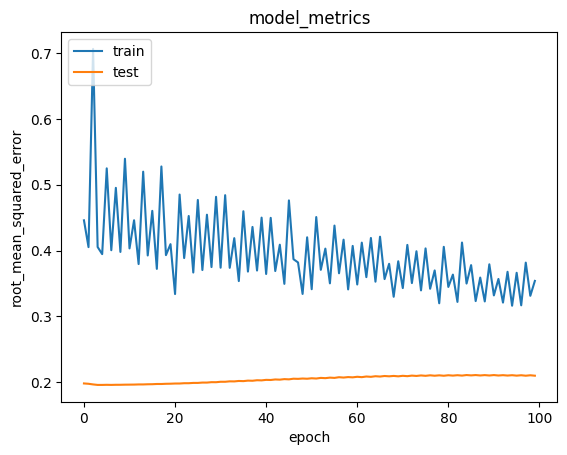

In [486]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

### Get Recommendation

In [505]:
user_id = movies.userId.sample(1).iloc[0]
movie_visited_by_user = movies[movies.userId == user_id]

movie_not_visited = movies[~movies['movieId'].isin(movie_visited_by_user.movieId.values)]['movieId']
movie_not_visited = list(
    set(movie_not_visited)
)

movie_not_visited = [[x] for x in movie_not_visited]
user_movie_array = np.hstack(
    ([[user_id]] * len(movie_not_visited), movie_not_visited)
)

In [510]:
ratings = model.predict(user_movie_array).flatten()
top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_movie_ids = [
    movie_encoded_to_movie.get(movie_not_visited[x][0]) for x in top_ratings_indices
]

print('Showing recommendations for users: {}'.format(user_id))
print('===' * 9)
print('movie with high ratings from user')
print('----' * 8)

top_movie_user = (
    movie_visited_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .movieId.values
)

data_rows = data[data['movieId'].isin(top_movie_user)]
high_rating = []
for row in data_rows.itertuples():
  if row.title in high_rating:
    continue
  else:
    high_rating.append(row.title)
  print(row.title, ':', row.genres)

print('----' * 8)
print('Top 10 movie recommendation')
print('----' * 8)

recommended_movie = data[data['title'].isin(recommended_movie_ids)]
recommended = []
for row in recommended_movie.itertuples():
  if row.title in recommended:
    continue
  else:
    recommended.append(row.title)
  print(row.title, ':', row.genres)

301/301 [==============================] - 2s 7ms/step
Showing recommendations for users: 320
movie with high ratings from user
--------------------------------
GoldenEye (1995) : Action|Adventure|Thriller
Rob Roy (1995) : Action|Drama|Romance|War
Something to Talk About (1995) : Comedy|Drama|Romance
Walk in the Clouds, A (1995) : Drama|Romance
I.Q. (1994) : Comedy|Romance
--------------------------------
Top 10 movie recommendation
--------------------------------
Streetcar Named Desire, A (1951) : Drama
Lawrence of Arabia (1962) : Adventure|Drama|War
Touch of Evil (1958) : Crime|Film-Noir|Thriller
Autumn Sonata (Höstsonaten) (1978) : Drama
Lifeboat (1944) : Drama|War
Guess Who's Coming to Dinner (1967) : Drama
Trial, The (Procès, Le) (1962) : Drama
Captain Fantastic (2016) : Drama
Band of Brothers (2001) : Action|Drama|War
Three Billboards Outside Ebbing, Missouri (2017) : Crime|Drama
